In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
#from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
#dropout_rate = 0.2
weight_decay = 1e-4

In [3]:
# Load CIFAR10 Data
from sklearn.model_selection import train_test_split
#from sklearn.utils import resample
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 
y_cv = tf.keras.utils.to_categorical(y_cv, num_classes) 

170500096/170498071 [==============================] - 2s 0us/step


In [4]:
X_train.shape

(40000, 32, 32, 3)

In [5]:
X_cv.shape

(10000, 32, 32, 3)

In [6]:
X_test.shape

(10000, 32, 32, 3)

In [0]:
# Dense Block
#https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    global weight_decay
    temp = input
    input_conv1 = num_filter*4
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization(beta_regularizer=regularizers.l2(weight_decay))(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(input_conv1),1, padding='same',kernel_initializer="he_normal",use_bias=False ,kernel_regularizer=regularizers.l2(weight_decay))(relu)

        BatchNorm = layers.BatchNormalization(beta_regularizer=regularizers.l2(weight_decay))(Conv2D_3_3)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_4 = layers.Conv2D(int(num_filter),3, padding='same',kernel_initializer="he_normal",use_bias=False ,kernel_regularizer=regularizers.l2(weight_decay))(relu)

        concat = layers.Concatenate()([temp,Conv2D_3_4])
        
        temp = concat
        
    return temp


## transition Blosck
#https://arthurdouillard.com/post/densenet/
def transition(input, num_filter = 12, dropout_rate = 0.2):
  
    global compression
    global weight_decay
    channel = input.shape.as_list()[-1]
    input_conv = channel*compression
    BatchNorm = layers.BatchNormalization(beta_regularizer=regularizers.l2(weight_decay))(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(input_conv), 1,use_bias=False ,padding='same',kernel_regularizer=regularizers.l2(weight_decay))(relu)
    Conv2D_BottleNeck = layers.Activation('relu')(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg


# #output layer
def output_layer(input):
    input_conv = num_filter*1
    BatchNorm = BatchNormalization(beta_regularizer=regularizers.l2(weight_decay))(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(8,8))(relu)
    #output = layers.Conv2D(10,1,use_bias=False ,padding='same',kernel_regularizer=regularizers.l2(weight_decay))(AvgPooling)
    #flat = Flatten()(AvgPooling)
    output = layers.Conv2D(10,1,use_bias=False ,padding='same',kernel_regularizer=regularizers.l2(weight_decay))(AvgPooling)
    output = Activation('softmax')(output)
    #output = AveragePooling2D(pool_size=(1,1))(output)
    output = Flatten()(output)
    #output  = BatchNormalization(beta_regularizer=regularizers.l2(weight_decay))(output)
   # output = Flatten()(output)
   # output = layers.Conv2D(num_classes,2, activation='softmax',kernel_regularizer=regularizers.l2(weight_decay))(flat)
   # output = layers.Dense(num_classes, activation='softmax')(flat)
    return output


In [8]:
from tensorflow.keras import regularizers 
num_filter = 12
dropout_rate = 0.2
l = 16
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(2*num_filter, 3, use_bias=False ,padding='same',bias_initializer='zeros',kernel_regularizer=regularizers.l2(weight_decay))(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)

output = output_layer(Third_Block)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
model1 = Model(inputs=[input], outputs=[output])
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
#https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    zoom_range=0.32,
    rotation_range=18,
 #   height_shift_range=0.1,
#     width_shift_range=0.1,
    horizontal_flip=True,
   # vertical_flip=True,
    rescale=1./255,
    fill_mode='nearest')

cv_datagen = ImageDataGenerator(
  #  zoom_range=0.32,
  #  rotation_range=18,
 #   height_shift_range=0.1,
#     width_shift_range=0.1,
  #  horizontal_flip=True,
   # vertical_flip=True,
    rescale=1./255,
#    fill_mode='nearest'
    )
test_datagen = ImageDataGenerator(
   # zoom_range=0.32,
 #   rotation_range=18,
 #   height_shift_range=0.1,
#     width_shift_range=0.1,
  #  horizontal_flip=True,
   # vertical_flip=True,
    rescale=1./255,
   # fill_mode='nearest'
    )

Using TensorFlow backend.


In [0]:
train_datagen.fit(X_train)
cv_datagen.fit(X_cv)
test_datagen.fit(X_test)

In [0]:
#https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/
epochs = 100
batch_size = 64
val_batch_size = 64
steps_per_epoch= len(y_train)//batch_size
validation_steps = len(y_test)//val_batch_size

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = "saved-model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

In [0]:
model1 = Model(inputs=[input], outputs=[output])


model1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-8),
              metrics=['acc'])

In [0]:
history = model1.fit_generator(train_datagen.flow(X_train, y_train ,batch_size=128
 ),steps_per_epoch=steps_per_epoch,
                    epochs=79,
                    validation_data=cv_datagen.flow(X_cv,y_cv,batch_size=128),validation_steps = validation_steps,callbacks = [checkpoint])

Epoch 1/79
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
156/625 [======>.......................] - ETA: 37s - loss: 2.1081 - acc: 0.3667
Epoch 00001: saving model to saved-model-01-0.37.hdf5
625/625 [==============================] - 280s 448ms/step - loss: 2.2554 - acc: 0.3875 - val_loss: 2.1081 - val_acc: 0.3667
Epoch 2/79
156/625 [======>.......................] - ETA: 28s - loss: 1.7780 - acc: 0.4872
Epoch 00002: saving model to saved-model-02-0.49.hdf5
625/625 [==============================] - 169s 270ms/step - loss: 1.8651 - acc: 0.4831 - val_loss: 1.7780 - val_acc: 0.4872
Epoch 3/79
156/625 [======>.......................] - ETA: 28s - loss: 1.5898 - acc: 0.5667
Epoch 00003: saving model to saved-model-03-0.57.hdf5
625/625 [==============================] - 168s 268ms/step - loss: 1.6028 - acc: 0.5752 - val_loss: 1.5898 - val_acc: 0.5667
Epoch 4/79
156/625 [======>.......................] - ETA: 28s - loss: 1.3909 - acc: 0.6286
E

In [0]:
from keras.models import load_model
best_model = tf.keras.models.load_model('saved-model-74-0.90.hdf5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


##### From epoch 74 , accuracy value of cv data = 0.9064. So test model is evalutated based on this model value.

In [0]:
# evaluate on test data
score1 = best_model.evaluate_generator(test_datagen.flow(X_test, y_test, batch_size=64), verbose=1)

157/157 [==============================] - 10s 64ms/step - loss: 0.5833 - acc: 0.9029


In [0]:
score1

[0.5833201007858203, 0.9029]

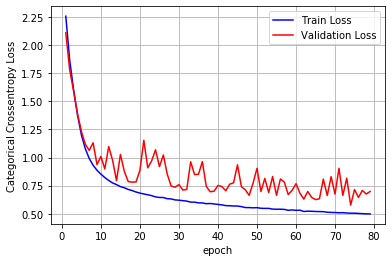

In [0]:
import pylab as plt
def plt_dynamic(x, vy, ty, ax, colors=['b']):
 ax.plot(x, vy, 'b', label="Train Loss")
 ax.plot(x, ty, 'r', label="Validation Loss")
 plt.legend()
 plt.grid()
 fig.canvas.draw()
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,80))
vy = history.history['loss']
ty = history.history['val_loss']
plt_dynamic(x, vy, ty, ax)

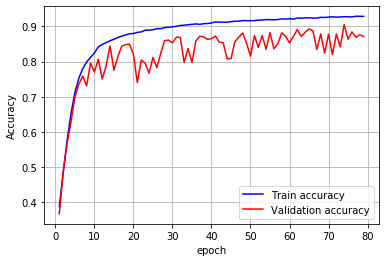

In [44]:
import pylab as plt
def plt_dynamic(x, vy, ty, ax, colors=['b']):
 ax.plot(x, vy, 'b', label="Train accuracy")
 ax.plot(x, ty, 'r', label="Validation accuracy")
 plt.legend()
 plt.grid()
 fig.canvas.draw()
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Accuracy')
# list of epoch numbers
x = list(range(1,80))
vy = history.history['acc']
ty = history.history['val_acc']
plt_dynamic(x, vy, ty, ax)

In [0]:
print("Test Accuracy {}". format(score1[1]))

Test Accuracy 0.902899980545044


#### Test Accuracy = 0.9029
